In [ ]:
!pip install xgboost imbalanced-learn

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# 1. Load and Clean Data
data = pd.read_csv('/content/cleaned_tweets (3).csv')

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower().strip()
    return text

data['final_text'] = data['text'].apply(clean_text)

In [ ]:

def enhanced_crisis_detection(tweet, sentiment):
    high_crisis_keywords = [
        'canceled', 'cancelled', 'stranded', 'emergency', 'disaster',
        'horrible', 'terrible', 'worst', 'chaos', 'nightmare', 'awful',
        'refund', 'compensation', 'lost luggage', 'missed connection',
        'hours delayed', 'never again', 'disgusting', 'furious'
    ]
    medium_crisis_keywords = [
        'delayed', 'late', 'poor service', 'bad experience',
        'unhappy', 'disappointed', 'frustrated', 'annoyed'
    ]
    tweet_lower = tweet.lower()
    high_crisis_count = sum(1 for keyword in high_crisis_keywords if keyword in tweet_lower)
    medium_crisis_count = sum(1 for keyword in medium_crisis_keywords if keyword in tweet_lower)
    crisis_score = 0
    crisis_score += high_crisis_count * 3
    crisis_score += medium_crisis_count * 1
    if sentiment == 'negative':
        crisis_score += 2
    elif sentiment == 'neutral':
        crisis_score += 0.5
    if crisis_score >= 4:
        return 'high_crisis'
    elif crisis_score >= 2:
        return 'medium_crisis'
    else:
        return 'non_crisis'

data['crisis_level'] = data.apply(
    lambda row: enhanced_crisis_detection(row['final_text'], row['airline_sentiment']), axis=1
)
def crisis_to_binary(crisis_level):
    if crisis_level in ['high_crisis', 'medium_crisis']:
        return 1
    return 0
data['crisis_binary'] = data['crisis_level'].apply(crisis_to_binary)

In [ ]:

# 2. Improved TF-IDF Features
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3),    # More context
    min_df=3,
    max_df=0.95,
    stop_words='english'
)
X = vectorizer.fit_transform(data['final_text']).toarray()
y = data['crisis_binary'].values

# 3. Split Data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:

# 4. Balance Data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 5. Model Definitions
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


In [ ]:

xgb_model = xgb.XGBClassifier(
    n_estimators=350,
    max_depth=10,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.85,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

lr_model = LogisticRegression(
    max_iter=1500,
    random_state=42,
    n_jobs=-1
)


In [ ]:

# 6. Ensemble (Voting) Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lr', lr_model)
    ],
    voting='soft',  # Use probabilities
    n_jobs=-1
)

# 7. Train Model
print("Training ensemble model...")
ensemble_model.fit(X_train_balanced, y_train_balanced)

Training ensemble model...


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=25,
                                                     min_samples_leaf=2,
                                                     min_samples_split=4,
                                                     n_estimators=250,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.85, device=None,
                                            early_stopping_rounds=None,...
                                            learning_rate=0.06, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=350, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lr',
                              LogisticRegression(max_iter=1500, n_jobs=-1,
                                                 random_state=42))],
                 n_jobs=-1, voting='soft')


Validation Set Results:
Accuracy: 0.7951
ROC-AUC: 0.8891
              precision    recall  f1-score   support

  Non-Crisis       0.68      0.80      0.74       789
      Crisis       0.88      0.79      0.83      1407

    accuracy                           0.80      2196
   macro avg       0.78      0.80      0.78      2196
weighted avg       0.81      0.80      0.80      2196



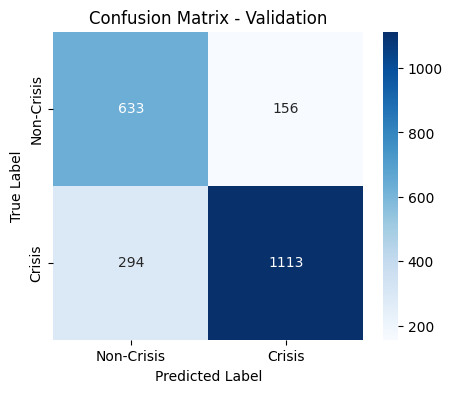


Test Set Results:
Accuracy: 0.8010
ROC-AUC: 0.8899
              precision    recall  f1-score   support

  Non-Crisis       0.68      0.84      0.75       790
      Crisis       0.90      0.78      0.83      1406

    accuracy                           0.80      2196
   macro avg       0.79      0.81      0.79      2196
weighted avg       0.82      0.80      0.80      2196



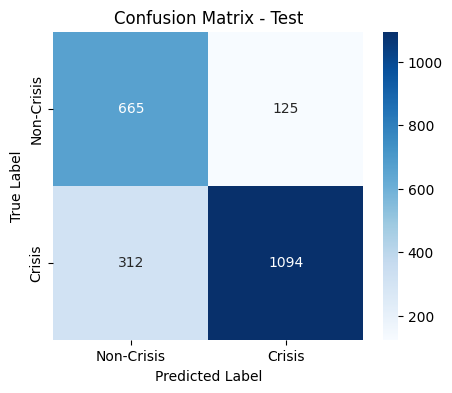

In [ ]:

# 8. Evaluate
def evaluate(model, X_val, y_val, X_test, y_test, threshold=0.5):
    for X_set, y_set, name in [(X_val, y_val, "Validation"), (X_test, y_test, "Test")]:
        proba = model.predict_proba(X_set)[:, 1]
        preds = (proba >= threshold).astype(int)
        acc = accuracy_score(y_set, preds)
        auc = roc_auc_score(y_set, proba)
        print(f"\n{name} Set Results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"ROC-AUC: {auc:.4f}")
        print(classification_report(y_set, preds, target_names=['Non-Crisis', 'Crisis']))
        cm = confusion_matrix(y_set, preds)
        labels = ['Non-Crisis', 'Crisis']
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

evaluate(ensemble_model, X_val, y_val, X_test, y_test, threshold=0.5)


In [ ]:
xgb_model.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:38:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=350,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 9. Feature Importance (XGBoost Only)
feature_names = vectorizer.get_feature_names_out()
feature_importance = xgb_model.feature_importances_
top_indices = feature_importance.argsort()[-20:][::-1]
print("\nTop 20 Most Important Features (XGBoost):")
print("-" * 40)
for i, idx in enumerate(top_indices):
    print(f"{i+1:2d}. {feature_names[idx]:20s} - {feature_importance[idx]:.4f}")



Top 20 Most Important Features (XGBoost):
----------------------------------------
 1. cancelled            - 0.0307
 2. flightled            - 0.0276
 3. hours                - 0.0089
 4. hold                 - 0.0085
 5. worst                - 0.0084
 6. hour                 - 0.0079
 7. cancelled flighted   - 0.0077
 8. fleets fleek         - 0.0073
 9. rude                 - 0.0070
10. delayed              - 0.0069
11. told                 - 0.0067
12. fleets               - 0.0067
13. refund               - 0.0063
14. thank                - 0.0051
15. wont                 - 0.0049
16. customer             - 0.0045
17. hrs                  - 0.0045
18. luggage              - 0.0044
19. phone                - 0.0043
20. thanks               - 0.0042


In [ ]:

# 10. Save Model & Vectorizer
joblib.dump(ensemble_model, 'ensemble_crisis_model.pkl')
joblib.dump(vectorizer, 'crisis_vectorizer.pkl')
print("\nEnsemble model and vectorizer saved successfully!")


Ensemble model and vectorizer saved successfully!


In [ ]:

# 11. Prediction Function
def predict_crisis_with_confidence(tweets, model, vectorizer, threshold=0.5):
    cleaned_tweets = [clean_text(tweet) for tweet in tweets]
    features = vectorizer.transform(cleaned_tweets).toarray()
    probabilities = model.predict_proba(features)
    preds = (probabilities[:,1] >= threshold).astype(int)
    results = []
    for tweet, pred, prob in zip(tweets, preds, probabilities):
        crisis_prob = prob[1]
        confidence = max(prob)
        result = {
            'tweet': tweet,
            'prediction': 'Crisis' if pred == 1 else 'Non-Crisis',
            'crisis_probability': crisis_prob,
            'confidence': confidence,
            'severity': 'High' if crisis_prob > 0.8 else 'Medium' if crisis_prob > 0.5 else 'Low'
        }
        results.append(result)
    return results


In [ ]:

# 12. Example Prediction
example_tweets = [
    "Flight canceled by Delta, I'm stranded at the airport for 8 hours!",
    "Slight delay with United, but crew was helpful",
    "Great experience with Southwest, smooth flight",
    "Emergency landing due to technical failure, terrible experience",
    "Lost my luggage and no one can help me, this is a nightmare!",
    "Food was okay, nothing special but acceptable service"
]
print("\n" + "="*60)
print("CRISIS PREDICTION RESULTS (Ensemble)")
print("="*60)
predictions = predict_crisis_with_confidence(example_tweets, ensemble_model, vectorizer)
for result in predictions:
    print(f"\nTweet: {result['tweet']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Crisis Probability: {result['crisis_probability']:.3f}")
    print(f"Confidence: {result['confidence']:.3f}")
    print(f"Severity Level: {result['severity']}")
    print("-" * 50)


CRISIS PREDICTION RESULTS (Ensemble)

Tweet: Flight canceled by Delta, I'm stranded at the airport for 8 hours!
Prediction: Crisis
Crisis Probability: 0.830
Confidence: 0.830
Severity Level: High
--------------------------------------------------

Tweet: Slight delay with United, but crew was helpful
Prediction: Crisis
Crisis Probability: 0.706
Confidence: 0.706
Severity Level: Medium
--------------------------------------------------

Tweet: Great experience with Southwest, smooth flight
Prediction: Non-Crisis
Crisis Probability: 0.225
Confidence: 0.775
Severity Level: Low
--------------------------------------------------

Tweet: Emergency landing due to technical failure, terrible experience
Prediction: Crisis
Crisis Probability: 0.743
Confidence: 0.743
Severity Level: Medium
--------------------------------------------------

Tweet: Lost my luggage and no one can help me, this is a nightmare!
Prediction: Crisis
Crisis Probability: 0.861
Confidence: 0.861
Severity Level: High
-----